# Predicting motor UPDRS score from vocal recordings
Parkinsons Telemarketing Dataset
Sean Gorman

In [1]:
import pandas as pd
import numpy as np

parkinsons = pd.read_csv("parkinsons_updrs.data")

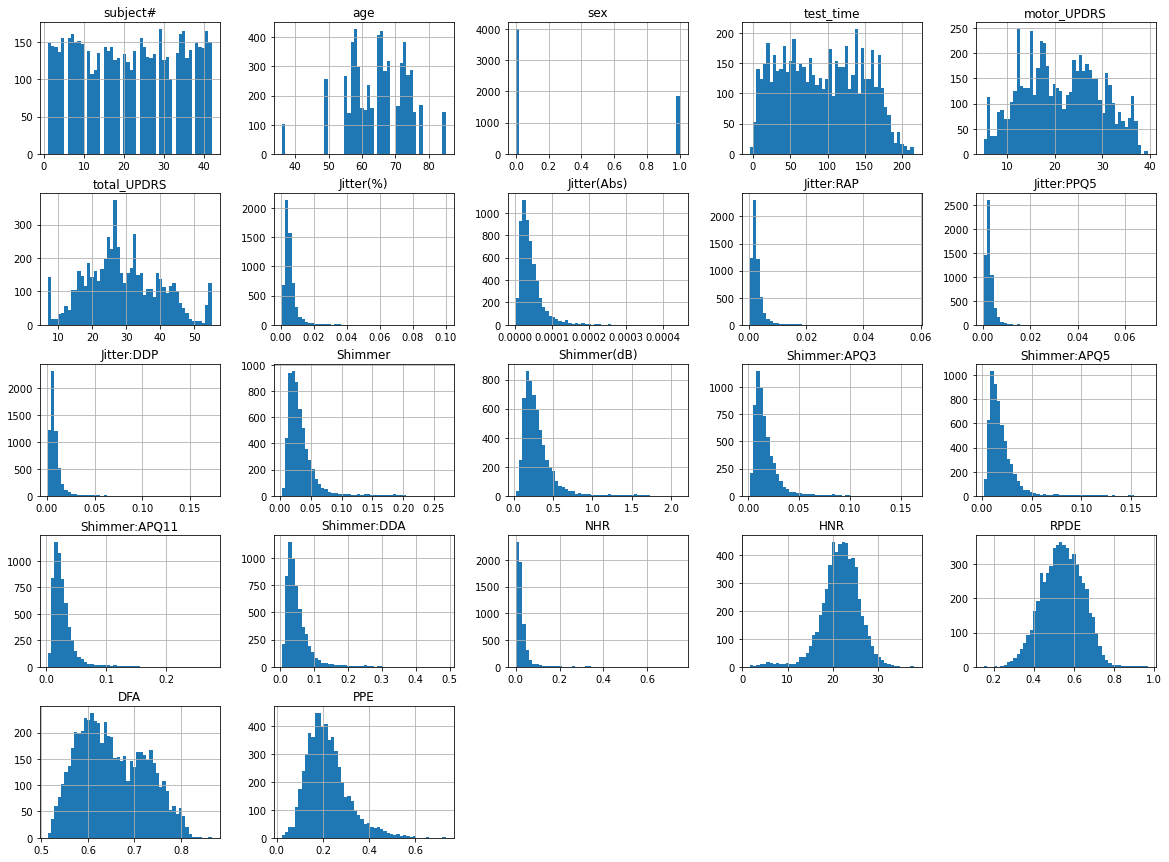

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
parkinsons.hist(bins=50, figsize=(20,15))
plt.show()

In [3]:
corr_matrix = parkinsons.corr()
corr_matrix["motor_UPDRS"].sort_values(ascending=False)

motor_UPDRS      1.000000
total_UPDRS      0.947231
age              0.273665
subject#         0.252919
PPE              0.162433
Shimmer:APQ11    0.136560
RPDE             0.128607
Shimmer(dB)      0.110076
Shimmer          0.102349
Shimmer:APQ5     0.092105
Jitter(%)        0.084816
Shimmer:APQ3     0.084261
Shimmer:DDA      0.084260
Jitter:PPQ5      0.076291
NHR              0.074967
Jitter:DDP       0.072698
Jitter:RAP       0.072684
test_time        0.067918
Jitter(Abs)      0.050903
sex             -0.031205
DFA             -0.116242
HNR             -0.157029
Name: motor_UPDRS, dtype: float64

In [4]:
parkinsons.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

# Regression models for motor_UPDRS

In [5]:
#removed total/motor_UPDRS, as well as test-time and subject number from data to simplify model 
data_columns = ['age', 'Jitter(%)', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ11', 'RPDE', 'PPE']
park = parkinsons[data_columns]
motor = parkinsons["motor_UPDRS"].copy()

park_array = park.to_numpy()
park_final = np.insert(park_array, 0, 1, axis=1)


In [6]:
#Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(park_final, motor.to_numpy(), test_size=0.2)


In [7]:
#Creating a scoring function to test and later select models
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr

def RegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

In [8]:
#Creating a K_Fold Cross Validation function 
from sklearn.model_selection import KFold

def k_fold_cv(model, data, labels):
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(data)
    TRUTH_nfold=None
    PREDS_nfold=None
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        mdl = model
        mdl.fit(X_train, y_train)
        preds = mdl.predict(X_test)
        if TRUTH_nfold is None:
            PREDS_nfold=preds
            TRUTH_nfold=y_test
        else:
            PREDS_nfold=np.hstack((PREDS_nfold, preds))
            TRUTH_nfold=np.hstack((TRUTH_nfold, y_test))

    print(RegStatistics(TRUTH_nfold, PREDS_nfold))

In [9]:
#Simple Linear Regressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.api import OLS,  add_constant

lin_reg = LinearRegression().fit(X_train, y_train)


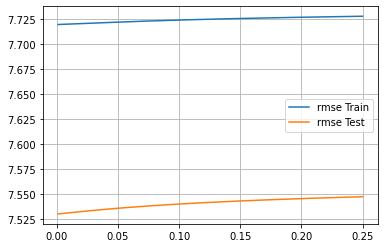

In [10]:
#Ridge Regressor 
#First finding optimal hyperparameter of alpha value 
import matplotlib.pyplot as plt

def find_alpha_ridge(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    rmse_train = []
    rmse_test = []
    alphas=2**np.arange(-2,-10,-.05)
    for alpha in alphas:
        ridge = Ridge(alpha=alpha, max_iter=100000).fit(X_train, y_train)
        preds_tr=ridge.predict(X_train)
        preds_te=ridge.predict(X_test)
        rmse_train.append(mean_squared_error(y_train, preds_tr, squared=False))
        rmse_test.append(mean_squared_error(y_test, preds_te, squared=False))

    plt.plot(alphas, rmse_train, label="rmse Train")    
    plt.plot(alphas, rmse_test, label="rmse Test")    
    plt.grid()
    plt.legend()
    plt.show()
    
find_alpha_ridge(X_train, y_train)

In [11]:
ridge = Ridge(alpha=.01, max_iter=9999999).fit(X_train, y_train)


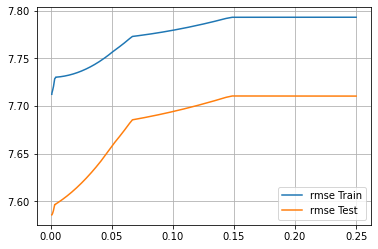

In [12]:
#Lasso Regressor 
#finding optimal hyperparameter of alpha value 

def find_alpha_lasso(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    rmse_train = []
    rmse_test = []
    alphas=2**np.arange(-2,-10,-.05)
    for alpha in alphas:
        L = Lasso(alpha=alpha, max_iter=100000).fit(X_train, y_train)
        preds_tr=L.predict(X_train)
        preds_te=L.predict(X_test)
        rmse_train.append(mean_squared_error(y_train, preds_tr, squared=False))
        rmse_test.append(mean_squared_error(y_test, preds_te, squared=False))

    plt.plot(alphas, rmse_train, label="rmse Train")    
    plt.plot(alphas, rmse_test, label="rmse Test")    
    plt.grid()
    plt.legend()
    plt.show()

find_alpha_lasso(X_train, y_train)

In [13]:
L = Lasso(alpha=.005, max_iter=9999999).fit(X_train, y_train)


In [14]:
# Decision Tree Regressor 
#First using GridSearch to find the optimal Hyperparameters 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = [
    {'max_depth':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'max_depth':[3, 10], 'max_features':[2, 3, 4]},
]

dt_reg = DecisionTreeRegressor()

grid_search = GridSearchCV(dt_reg, param_grid, cv=10,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

DecisionTreeRegressor(max_depth=10, max_features=8)

In [15]:
dt = grid_search.best_estimator_

In [16]:
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [17]:
frst_reg = grid_search.best_estimator_

In [18]:
models = [lin_reg, ridge, L, dt, frst_reg]

for mdl in models:
    print("The stats for {} are as follows:".format(mdl))
    k_fold_cv(mdl, X_train, y_train)
    print("\n")

The stats for LinearRegression() are as follows:
The RVE is:  0.09720233113421817
The rmse is:  7.691740763220167
The Correlation Score is is: 0.3118 (p-value=1.685198e-106)

The Maximum Error is is:  20.137719612348093
The Mean Absolute Error is:  6.583361928055663
None


The stats for Ridge(alpha=0.01, max_iter=9999999) are as follows:
The RVE is:  0.09648191173865073
The rmse is:  7.694809471936357
The Correlation Score is is: 0.3107 (p-value=1.099496e-105)

The Maximum Error is is:  20.083094402533106
The Mean Absolute Error is:  6.580856787297078
None


The stats for Lasso(alpha=0.005, max_iter=9999999) are as follows:
The RVE is:  0.09246816108683487
The rmse is:  7.711881647144545
The Correlation Score is is: 0.3041 (p-value=3.961733e-101)

The Maximum Error is is:  19.93022946363676
The Mean Absolute Error is:  6.601990030886598
None


The stats for DecisionTreeRegressor(max_depth=10, max_features=8) are as follows:
The RVE is:  0.6983681962607275
The rmse is:  4.44613147119224

In [19]:
## The random forest regressor seems to be the best. We'll go with that for the selection. 

In [20]:
# test selected model on the independent validation set
frst_reg.fit(X_train, y_train)
preds = frst_reg.predict(X_test)
RegStatistics(y_test, preds)

The RVE is:  0.7696195508663525
The rmse is:  3.9651473069315633
The Correlation Score is is: 0.8776 (p-value=0.000000e+00)

The Maximum Error is is:  19.413933333333336
The Mean Absolute Error is:  2.7407672737588653


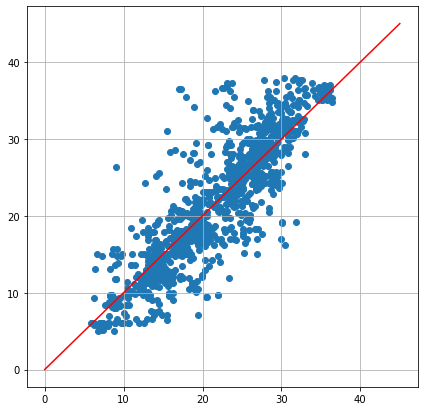

In [23]:
#Plotting predicted y values against actual y values
plt.figure(figsize=(7,7))
plt.scatter(preds, y_test)
plt.grid()
#this is the 45degrees angle. The closer the predictions approach this, the better the model
plt.plot([0,45], [0,45], c="r")
plt.show()